In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel


In [11]:
import warnings

warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv("combined_sentiment_data.csv")

In [13]:
df.head()

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,cons_sentiment,headline_sentiment,pros_sentiment
0,AFH-Wealth-Management,2015-04-05,,Current Employee,Unknown,2,4.0,3.0,2.0,3.0,3.0,-1,1,2,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",-3,-2,3
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",2,3.0,1.0,2.0,1.0,4.0,-1,1,2,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,-1,1,3
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",1,1.0,1.0,1.0,1.0,1.0,-1,1,-1,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",-2,-3,2
3,AFH-Wealth-Management,2016-04-16,,Current Employee,Unknown,5,2.0,3.0,2.0,2.0,3.0,-1,1,2,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,-2,2,2
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",1,2.0,1.0,2.0,1.0,1.0,-1,1,-1,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",-1,0,3


In [14]:
cols = df.columns
cols

Index(['firm', 'date_review', 'job_title', 'current', 'location',
       'overall_rating', 'work_life_balance', 'culture_values', 'career_opp',
       'comp_benefits', 'senior_mgmt', 'recommend', 'ceo_approv', 'outlook',
       'headline', 'pros', 'cons', 'cons_sentiment', 'headline_sentiment',
       'pros_sentiment'],
      dtype='object')

In [15]:
df.isnull().sum()

firm                  0
date_review           0
job_title             0
current               0
location              0
overall_rating        0
work_life_balance     0
culture_values        0
career_opp            0
comp_benefits         0
senior_mgmt           0
recommend             0
ceo_approv            0
outlook               0
headline              0
pros                  0
cons                  0
cons_sentiment        0
headline_sentiment    0
pros_sentiment        0
dtype: int64

In [16]:
df.duplicated().any()

False

In [17]:
df.shape

(805051, 20)

In [18]:
import category_encoders as ce

In [19]:
from sklearn.metrics import accuracy_score

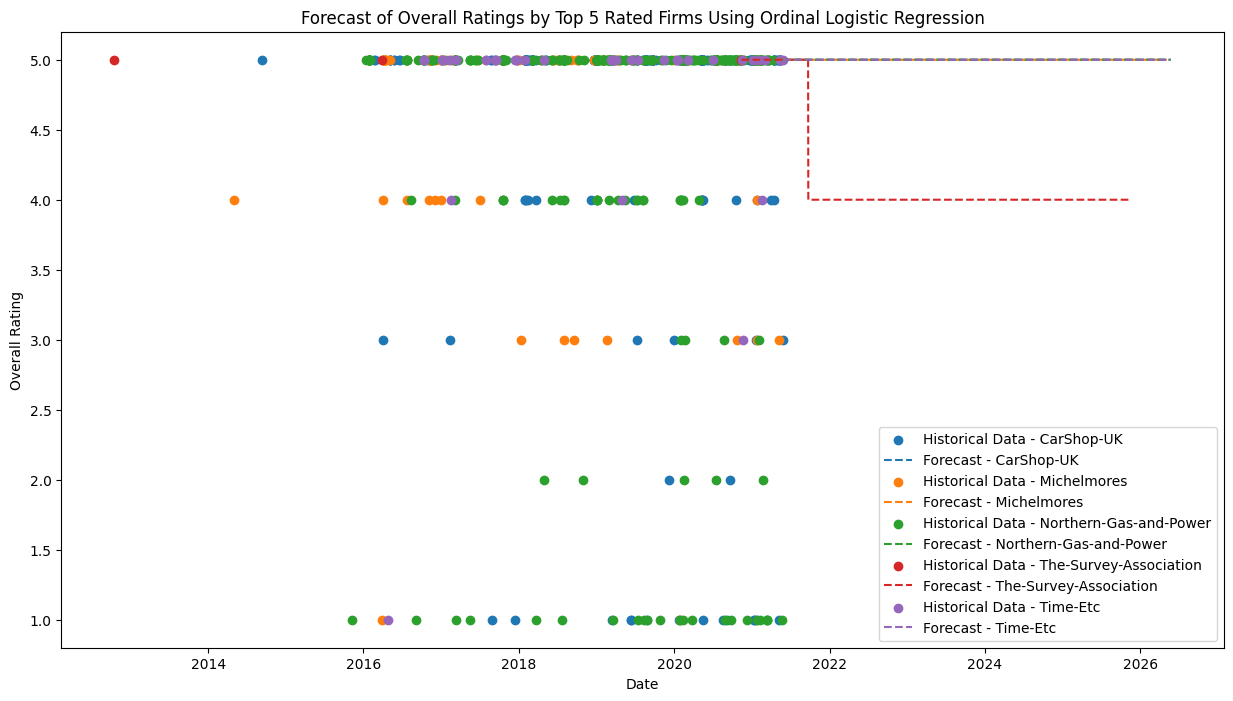

CarShop-UK - 2020 Rating: 4.75, 2026 Predicted Rating: 5.00
Michelmores - 2020 Rating: 3.80, 2026 Predicted Rating: 5.00
Northern-Gas-and-Power - 2020 Rating: 4.75, 2026 Predicted Rating: 5.00
The-Survey-Association - 2020 Rating: 5.00, 2026 Predicted Rating: nan
Time-Etc - 2020 Rating: 4.67, 2026 Predicted Rating: 5.00


In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Sample DataFrame loading
# df = pd.DataFrame(data)

# Ensure 'date_review' is in datetime format
df['date_review'] = pd.to_datetime(df['date_review'])

# Creating a numeric time variable for regression analysis
df['time'] = (df['date_review'] - df['date_review'].min()) / np.timedelta64(1, 'D')

# Encoding categorical variables
label_encoders = {}
for column in ['job_title', 'location', 'current']:
    le = LabelEncoder()
    df[column + '_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

# Prepare the data
predictors = ['time', 'job_title_encoded', 'current_encoded', 'location_encoded',
              'work_life_balance', 'culture_values', 'career_opp', 'comp_benefits',
              'senior_mgmt', 'recommend', 'ceo_approv', 'outlook', 'cons_sentiment', 'headline_sentiment',
              'pros_sentiment']
X = df[predictors]
y = pd.Categorical(df['overall_rating'], ordered=True)

# Identify and remove constant columns
constant_columns = [col for col in X.columns if X[col].nunique(dropna=False) == 1]
if constant_columns:
    print(f"Removing constant columns: {constant_columns}")
    X = X.drop(columns=constant_columns)

# Calculate average ratings for each firm
average_ratings = df.groupby('firm')['overall_rating'].mean()

# Identify top 5 firms based on average ratings
top_5_firms = average_ratings.nlargest(5).index

# Filter the DataFrame to include only top 5 firms
df_top5 = df[df['firm'].isin(top_5_firms)]

# Splitting the dataset into training and test sets specifically for top 5 firms
X_train, X_test, y_train, y_test = train_test_split(df_top5[predictors], pd.Categorical(df_top5['overall_rating'], ordered=True), test_size=0.2, random_state=42)

# Fit the ordinal logistic regression model on the training data
model = OrderedModel(y_train, X_train, distr='logit')
result = model.fit(method='bfgs', disp=0)  # Fit the model silently

# Assuming predictions and plotting need to be made for each firm
predictions = {}
plt.figure(figsize=(15, 8))

for name, group in df_top5.groupby('firm'):
    # Latest rating for 2020
    ratings_2020 = group[group['date_review'].dt.year == 2020]['overall_rating'].mean() if not group[group['date_review'].dt.year == 2020].empty else np.nan

    last_date = group['date_review'].max()
    future_times = np.arange(1, 365 * 5 + 1, 1)
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(future_times), freq='D')
    X_future = pd.DataFrame({'time': future_times + group['time'].max()}, columns=['time'])

    # Assuming other features remain constant
    for col in predictors[1:]:  # Skip 'time' as it's already in X_future
        X_future[col] = group[col].mode()[0] if group[col].dtype == 'int' else group[col].mean()

    # Predicting future ratings
    future_probabilities = result.predict(X_future)
    future_ratings = np.argmax(future_probabilities, axis=1) + 1  # Convert probabilities to most likely category

    # Cap ratings at 5
    future_ratings = np.minimum(future_ratings, 5)

    # Predicted rating for 2026
    future_dates_2026 = future_dates.year == 2026
    if np.any(future_dates_2026):
        predicted_2026_rating = future_ratings[future_dates_2026][0]
    else:
        predicted_2026_rating = np.nan  # Handle case where 2026 is not covered

    # Store predictions
    predictions[name] = {'2020': ratings_2020, '2026': predicted_2026_rating}
    
    # Plotting
    plt.scatter(group['date_review'], group['overall_rating'], label=f'Historical Data - {name}')
    plt.plot(future_dates, future_ratings, linestyle='--', label=f'Forecast - {name}')

plt.title('Forecast of Overall Ratings by Top 5 Rated Firms Using Ordinal Logistic Regression')
plt.xlabel('Date')
plt.ylabel('Overall Rating')
plt.legend()
plt.show()

# Displaying the predictions for 2020 and 2026 for each top 5 firm
for firm, ratings in predictions.items():
    print(f"{firm} - 2020 Rating: {ratings['2020']:.2f}, 2026 Predicted Rating: {ratings['2026']:.2f}")


In [21]:
# List of specific firms you want to count
specific_firms = [
    "CarShop-UK",
    "Michelmores",
    "Northern-Gas-and-Power",
    "The-Survey-Association",
    "Time-Etc"
]

# Count occurrences of each firm in the 'firm' column
firm_counts = df['firm'].value_counts()

# Filter the counts to show only the specific firms
specific_firm_counts = firm_counts[firm_counts.index.isin(specific_firms)]

# Print the counts for these specific firms
print(specific_firm_counts)


firm
Northern-Gas-and-Power    503
CarShop-UK                258
Michelmores                77
Time-Etc                   42
The-Survey-Association      3
Name: count, dtype: int64


The rating prediction for The-Survey-Association raises a question. The nan rating can be because of absence of data for this specific firm .

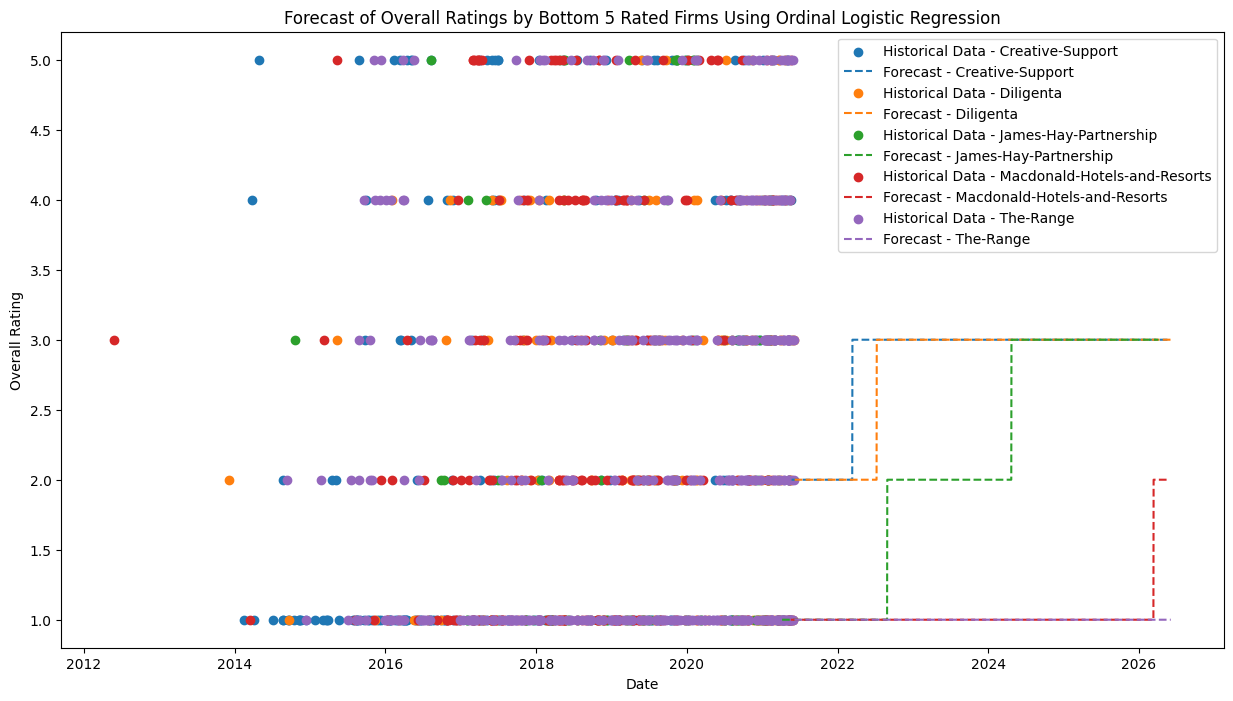

Creative-Support - 2020 Rating: 2.63, 2026 Predicted Rating: 3.00
Diligenta - 2020 Rating: 2.25, 2026 Predicted Rating: 3.00
James-Hay-Partnership - 2020 Rating: 2.33, 2026 Predicted Rating: 3.00
Macdonald-Hotels-and-Resorts - 2020 Rating: 2.89, 2026 Predicted Rating: 1.00
The-Range - 2020 Rating: 2.27, 2026 Predicted Rating: 1.00


In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df is already loaded and the 'date_review' column is datetime type

# Convert 'date_review' to datetime if not already
df['date_review'] = pd.to_datetime(df['date_review'])

# Creating a numeric time variable for regression analysis
df['time'] = (df['date_review'] - df['date_review'].min()) / np.timedelta64(1, 'D')

# Encoding categorical variables
label_encoders = {}
for column in ['job_title', 'location', 'current']:
    le = LabelEncoder()
    df[column + '_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

# Prepare the data
predictors = ['time', 'job_title_encoded', 'current_encoded', 'location_encoded',
              'work_life_balance', 'culture_values', 'career_opp', 'comp_benefits',
              'senior_mgmt', 'recommend', 'ceo_approv', 'outlook']
X = df[predictors]
y = pd.Categorical(df['overall_rating'], ordered=True)

# Identify and remove constant columns
constant_columns = [col for col in X.columns if X[col].nunique(dropna=False) == 1]
if constant_columns:
    print(f"Removing constant columns: {constant_columns}")
    X = X.drop(columns=constant_columns)

# Calculate average ratings for each firm
average_ratings = df.groupby('firm')['overall_rating'].mean()

# Identify bottom 5 firms based on average ratings
bottom_5_firms = average_ratings.nsmallest(5).index

# Filter the DataFrame to include only bottom 5 firms
df_bottom5 = df[df['firm'].isin(bottom_5_firms)]

# Splitting the dataset into training and test sets specifically for bottom 5 firms
X_train, X_test, y_train, y_test = train_test_split(df_bottom5[predictors], pd.Categorical(df_bottom5['overall_rating'], ordered=True), test_size=0.2, random_state=42)

# Fit the ordinal logistic regression model on the training data
model = OrderedModel(y_train, X_train, distr='logit')
result = model.fit(method='bfgs', disp=0)  # Fit the model silently

# Assuming predictions and plotting need to be made for each firm
predictions = {}
plt.figure(figsize=(15, 8))

for name, group in df_bottom5.groupby('firm'):
    # Latest rating for 2020
    ratings_2020 = group[group['date_review'].dt.year == 2020]['overall_rating'].mean() if not group[group['date_review'].dt.year == 2020].empty else np.nan

    last_date = group['date_review'].max()
    future_times = np.arange(1, 365 * 5 + 1, 1)
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(future_times), freq='D')
    X_future = pd.DataFrame({'time': future_times + group['time'].max()}, columns=['time'])

    # Assuming other features remain constant
    for col in predictors[1:]:  # Skip 'time' as it's already in X_future
        X_future[col] = group[col].mode()[0] if group[col].dtype == 'int' else group[col].mean()

    # Predicting future ratings
    future_probabilities = result.predict(X_future)
    future_ratings = np.argmax(future_probabilities, axis=1) + 1  # Convert probabilities to most likely category

    # Cap ratings at 5
    future_ratings = np.minimum(future_ratings, 5)

    # Predicted rating for 2026
    future_dates_2026 = future_dates.year == 2026
    if np.any(future_dates_2026):
        predicted_2026_rating = future_ratings[future_dates_2026][0]
    else:
        predicted_2026_rating = np.nan  # Handle case where 2026 is not covered

    # Store predictions
    predictions[name] = {'2020': ratings_2020, '2026': predicted_2026_rating}
    
    # Plotting
    plt.scatter(group['date_review'], group['overall_rating'], label=f'Historical Data - {name}')
    plt.plot(future_dates, future_ratings, linestyle='--', label=f'Forecast - {name}')

plt.title('Forecast of Overall Ratings by Bottom 5 Rated Firms Using Ordinal Logistic Regression')
plt.xlabel('Date')
plt.ylabel('Overall Rating')
plt.legend()
plt.show()

# Displaying the predictions for 2020 and 2026 for each bottom 5 firm
for firm, ratings in predictions.items():
    print(f"{firm} - 2020 Rating: {ratings['2020']:.2f}, 2026 Predicted Rating: {ratings['2026']:.2f}")


In [24]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Loading and preparing your DataFrame
# Assume 'df' is your DataFrame loaded appropriately here
# df = pd.read_csv('your_data.csv')

# Ensure 'date_review' is in datetime format
df['date_review'] = pd.to_datetime(df['date_review'])

# Encoding categorical variables
label_encoders = {}
for column in ['job_title', 'location', 'current']:
    le = LabelEncoder()
    df[column + '_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

# Creating a numeric time variable for regression analysis
df['time'] = (df['date_review'] - df['date_review'].min()) / np.timedelta64(1, 'D')

# Filtering data by year
df_2020_2021 = df[df['date_review'].dt.year.isin([2020, 2021])]
df_2022 = df[df['date_review'].dt.year == 2022]

# Preparing features and target
predictors = ['time', 'job_title_encoded', 'current_encoded', 'location_encoded', 'work_life_balance', 
              'culture_values', 'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 
              'ceo_approv', 'outlook']
X_train = df_2020_2021[predictors]
y_train = pd.Categorical(df_2020_2021['overall_rating'], ordered=True)
X_test = df_2022[predictors]
y_test = pd.Categorical(df_2022['overall_rating'], ordered=True)

# Train the ordinal logistic regression model
model = OrderedModel(y_train, X_train, distr='logit')
result = model.fit(method='bfgs', disp=0)

# Test the model
predicted_probabilities = result.predict(X_test)
y_pred = np.argmax(predicted_probabilities, axis=1) + 1  # to adjust index starting at 0 to rating scale starting at 1

# Evaluate the model
accuracy = accuracy_score(y_test.codes, y_pred - 1)  # adjust y_pred to zero-based index for comparison
precision, recall, f1, _ = precision_recall_fscore_support(y_test.codes, y_pred - 1, average='weighted')
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Predict for 2026
future_time = (pd.Timestamp('2026-01-01') - df['date_review'].min()) / np.timedelta64(1, 'D')
X_future = X_test.copy()
X_future['time'] = future_time
future_probabilities = result.predict(X_future)
future_predictions = np.argmax(future_probabilities, axis=1) + 1

# Add top firms analysis
df_2022['predicted_rating'] = y_pred
average_ratings_2020 = df[df['date_review'].dt.year == 2020].groupby('firm')['overall_rating'].mean()
average_ratings_2022 = df_2022.groupby('firm')['predicted_rating'].mean()
df_future = df_2022.copy()
df_future['predicted_rating'] = future_predictions
average_ratings_2026 = df_future.groupby('firm')['predicted_rating'].mean()

top_firms_2020 = average_ratings_2020.nlargest(10)
top_firms_2022 = average_ratings_2022.nlargest(10)
top_firms_2026 = average_ratings_2026.nlargest(10)

print("Top 10 Firms by 2020 Ratings:\n", top_firms_2020)
print("Top 10 Firms by 2022 Predicted Ratings:\n", top_firms_2022)
print("Top 10 Firms by 2026 Predicted Ratings:\n", top_firms_2026)


Accuracy: nan, Precision: nan, Recall: nan, F1 Score: nan
Top 10 Firms by 2020 Ratings:
 firm
Achieving-for-Children                                5.000000
ActionCOACH                                           5.000000
AlixPartners                                          5.000000
Engineering-and-Physical-Sciences-Research-Council    5.000000
Office-of-Rail-Regulation                             5.000000
The-National-Gallery                                  5.000000
The-Survey-Association                                5.000000
Abcam                                                 4.911765
Northern-Gas-and-Power                                4.752941
CarShop-UK                                            4.747664
Name: overall_rating, dtype: float64
Top 10 Firms by 2022 Predicted Ratings:
 Series([], Name: predicted_rating, dtype: float64)
Top 10 Firms by 2026 Predicted Ratings:
 Series([], Name: predicted_rating, dtype: float64)


In [32]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Assume 'df' is your DataFrame
df['date_review'] = pd.to_datetime(df['date_review'])

label_encoders = {}
for column in ['job_title', 'location', 'current']:
    le = LabelEncoder()
    df[column + '_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

df['time'] = (df['date_review'] - df['date_review'].min()) / np.timedelta64(1, 'D')
df_training = df[df['date_review'].dt.year.isin(range(2014, 2021))]
df_2021 = df[df['date_review'].dt.year == 2021]

predictors = ['time', 'job_title_encoded', 'current_encoded', 'location_encoded', 'work_life_balance', 
              'culture_values', 'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 
              'ceo_approv', 'outlook']
X_train = df_training[predictors]
y_train = pd.Categorical(df_training['overall_rating'], ordered=True)
X_2021 = df_2021[predictors]
y_2021 = pd.Categorical(df_2021['overall_rating'], ordered=True)

model = OrderedModel(y_train, X_train, distr='logit')
result = model.fit(method='bfgs', disp=0)

predicted_probabilities_2021 = result.predict(X_2021)
y_pred_2021 = np.argmax(predicted_probabilities_2021, axis=1) + 1
df_2021['predicted_rating'] = y_pred_2021

accuracy_2021 = accuracy_score(y_2021.codes, y_pred_2021 - 1)
precision_2021, recall_2021, f1_2021, _ = precision_recall_fscore_support(y_2021.codes, y_pred_2021 - 1, average='weighted')
print(f"Accuracy for 2021 Predictions: {accuracy_2021}, Precision: {precision_2021}, Recall: {recall_2021}, F1 Score: {f1_2021}")

future_time = (pd.Timestamp('2026-01-01') - df['date_review'].min()) / np.timedelta64(1, 'D')
X_future = df_2021.copy()
X_future['time'] = future_time
future_probabilities = result.predict(X_future[predictors])
future_predictions = np.argmax(future_probabilities, axis=1) + 1
df_2021['predicted_rating_2026'] = future_predictions

print("Top 10 Firms by 2015 Ratings:\n", df[df['date_review'].dt.year == 2015].groupby('firm')['overall_rating'].mean().nlargest(10))
print("Top 10 Firms by 2021 Predicted Ratings:\n", df_2021.groupby('firm')['predicted_rating'].mean().nlargest(10))
print("Top 10 Firms by 2026 Predicted Ratings:\n", df_2021.groupby('firm')['predicted_rating_2026'].mean().nlargest(10))


Accuracy for 2021 Predictions: 0.3859439628817034, Precision: 0.38963544688707147, Recall: 0.3859439628817034, F1 Score: 0.3583059555991156
Top 10 Firms by 2015 Ratings:
 firm
Anglian-Water                                         5.0
Barnett-Waddingham                                    5.0
Engineering-and-Physical-Sciences-Research-Council    5.0
Newcastle-Upon-Tyne-Hospitals-NHS                     5.0
Rathbone-Brothers                                     5.0
Scottish-Courts-and-Tribunals-Service                 5.0
Somerset-County-Council                               5.0
TLT                                                   5.0
UHMBT                                                 5.0
mydentist-UK                                          5.0
Name: overall_rating, dtype: float64
Top 10 Firms by 2021 Predicted Ratings:
 firm
UHMBT                                   5.000000
UK-Border-Agency                        5.000000
Western-Health-and-Social-Care-Trust    5.000000
RWE-Supply-and

In [27]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

df['date_review'] = pd.to_datetime(df['date_review'])

# Encoding categorical variables
label_encoders = {}
for column in ['job_title', 'location', 'current']:
    le = LabelEncoder()
    df[column + '_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

# Create a numeric time variable for regression analysis
df['time'] = (df['date_review'] - df['date_review'].min()) / np.timedelta64(1, 'D')

# Filter data by year for training and testing
df_train = df[df['date_review'].dt.year.isin([2014, 2015])]
df_test = df[df['date_review'].dt.year == 2016]

# Prepare features and target
predictors = ['time', 'job_title_encoded', 'current_encoded', 'location_encoded', 'work_life_balance', 
              'culture_values', 'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 
              'ceo_approv', 'outlook']
X_train = df_train[predictors]
y_train = pd.Categorical(df_train['overall_rating'], ordered=True)
X_test = df_test[predictors]
y_test = pd.Categorical(df_test['overall_rating'], ordered=True)

# Train the ordinal logistic regression model
model = OrderedModel(y_train, X_train, distr='logit')
result = model.fit(method='bfgs', disp=0)

# Predict for 2016
predicted_probabilities = result.predict(X_test)
y_pred = np.argmax(predicted_probabilities, axis=1) + 1  # Adjust index to rating scale

# Evaluate the model
accuracy = accuracy_score(y_test.codes, y_pred - 1)  # Adjust y_pred to zero-based index for comparison
precision, recall, f1, _ = precision_recall_fscore_support(y_test.codes, y_pred - 1, average='weighted')

# Display the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.49741284562283117
Precision: 0.5092829749738975
Recall: 0.49741284562283117
F1 Score: 0.491079960153839


In [29]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Load your DataFrame (Assume 'df' is already loaded with data)
# Ensure 'date_review' is in datetime format
df['date_review'] = pd.to_datetime(df['date_review'])

# Encoding categorical variables
label_encoders = {}
for column in ['job_title', 'location', 'current']:
    le = LabelEncoder()
    df[column + '_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

# Create a numeric time variable for regression analysis
df['time'] = (df['date_review'] - df['date_review'].min()) / np.timedelta64(1, 'D')

# Filter data by year for training and testing
df_train = df[df['date_review'].dt.year.isin([2014, 2015])]
df_test = df[df['date_review'].dt.year == 2016]

# Prepare features and target
predictors = ['time', 'job_title_encoded', 'current_encoded', 'location_encoded', 'work_life_balance', 
              'culture_values', 'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 
              'ceo_approv', 'outlook']
X_train = df_train[predictors]
y_train = pd.Categorical(df_train['overall_rating'], ordered=True)
X_test = df_test[predictors]
y_test = pd.Categorical(df_test['overall_rating'], ordered=True)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame to keep the structure
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Train the ordinal logistic regression model with scaled data
model = OrderedModel(y_train, X_train_scaled_df, distr='logit')
result = model.fit(method='bfgs', disp=0)

# Predict for 2016
predicted_probabilities = result.predict(X_test_scaled_df)
y_pred = np.argmax(predicted_probabilities, axis=1) + 1  # Adjust index to rating scale

# Evaluate the model
accuracy = accuracy_score(y_test.codes, y_pred - 1)  # Adjust y_pred to zero-based index for comparison
precision, recall, f1, _ = precision_recall_fscore_support(y_test.codes, y_pred - 1, average='weighted')

# Display the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.49742519480840236
Precision: 0.5092842382289887
Recall: 0.49742519480840236
F1 Score: 0.4910900344110791


In [30]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load your DataFrame (Assume 'df' is already loaded with data)
# Ensure 'date_review' is in datetime format
df['date_review'] = pd.to_datetime(df['date_review'])

# Encoding categorical variables
label_encoders = {}
for column in ['job_title', 'location', 'current']:
    le = LabelEncoder()
    df[column + '_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

# Create a numeric time variable for regression analysis
df['time'] = (df['date_review'] - df['date_review'].min()) / np.timedelta64(1, 'D')

# Filter data by year for training and testing
training_years = [2014, 2015, 2016, 2018]
df_train = df[df['date_review'].dt.year.isin(training_years)]
df_test = df[df['date_review'].dt.year == 2019]

# Prepare features and target
predictors = ['time', 'job_title_encoded', 'current_encoded', 'location_encoded', 'work_life_balance', 
              'culture_values', 'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 
              'ceo_approv', 'outlook']
X_train = df_train[predictors]
y_train = pd.Categorical(df_train['overall_rating'], ordered=True)
X_test = df_test[predictors]
y_test = pd.Categorical(df_test['overall_rating'], ordered=True)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame to keep the structure
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Train the ordinal logistic regression model with scaled data
model = OrderedModel(y_train, X_train_scaled_df, distr='logit')
result = model.fit(method='bfgs', disp=0)

# Predict for 2019
predicted_probabilities = result.predict(X_test_scaled_df)
y_pred = np.argmax(predicted_probabilities, axis=1) + 1  # Adjust index to rating scale

# Evaluate the model
accuracy = accuracy_score(y_test.codes, y_pred - 1)  # Adjust y_pred to zero-based index for comparison
precision, recall, f1, _ = precision_recall_fscore_support(y_test.codes, y_pred - 1, average='weighted')

# Display the evaluation metrics
print(f"Accuracy for 2019 predictions: {accuracy}")
print(f"Precision for 2019 predictions: {precision}")
print(f"Recall for 2019 predictions: {recall}")
print(f"F1 Score for 2019 predictions: {f1}")



Accuracy for 2019 predictions: 0.4592409905375478
Precision for 2019 predictions: 0.46994170665655305
Recall for 2019 predictions: 0.4592409905375478
F1 Score for 2019 predictions: 0.4443753925427464


In [31]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load your DataFrame (Assume 'df' is already loaded with data)
# Ensure 'date_review' is in datetime format
df['date_review'] = pd.to_datetime(df['date_review'])

# Encoding categorical variables
label_encoders = {}
for column in ['job_title', 'location', 'current']:
    le = LabelEncoder()
    df[column + '_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

# Create a numeric time variable for regression analysis
df['time'] = (df['date_review'] - df['date_review'].min()) / np.timedelta64(1, 'D')

# Filter data by year for training and testing
training_years = [2014, 2015, 2016, 2018, 2019]  # Now includes 2019
df_train = df[df['date_review'].dt.year.isin(training_years)]
df_test = df[df['date_review'].dt.year == 2020]  # Testing on 2020 data

# Prepare features and target
predictors = ['time', 'job_title_encoded', 'current_encoded', 'location_encoded', 'work_life_balance', 
              'culture_values', 'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 
              'ceo_approv', 'outlook']
X_train = df_train[predictors]
y_train = pd.Categorical(df_train['overall_rating'], ordered=True)
X_test = df_test[predictors]
y_test = pd.Categorical(df_test['overall_rating'], ordered=True)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame to keep the structure
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Train the ordinal logistic regression model with scaled data
model = OrderedModel(y_train, X_train_scaled_df, distr='logit')
result = model.fit(method='bfgs', disp=0)

# Predict for 2020
predicted_probabilities = result.predict(X_test_scaled_df)
y_pred = np.argmax(predicted_probabilities, axis=1) + 1  # Adjust index to rating scale

# Evaluate the model
accuracy = accuracy_score(y_test.codes, y_pred - 1)  # Adjust y_pred to zero-based index for comparison
precision, recall, f1, _ = precision_recall_fscore_support(y_test.codes, y_pred - 1, average='weighted')

# Display the evaluation metrics
print(f"Accuracy for 2020 predictions: {accuracy}")
print(f"Precision for 2020 predictions: {precision}")
print(f"Recall for 2020 predictions: {recall}")
print(f"F1 Score for 2020 predictions: {f1}")


Accuracy for 2020 predictions: 0.43456124145575464
Precision for 2020 predictions: 0.4469979064983333
Recall for 2020 predictions: 0.43456124145575464
F1 Score for 2020 predictions: 0.42060848500237696
